In [723]:
import numpy as np
import matplotlib.pyplot as plt

In [724]:
#plota estrutura original e deslocada, para n malhas com sequencias de pontos x,y e número de graus de liberdade
def plot_desloc(x, y, store, numGlib, scale=100,fig_size=(10, 6), info_o = [{"color":"ro-","label":"Estrutura Original"}], info_d = [{"color":"bo-","label":"Estrutura Deslocada"}]):
    if(len(x)!=len(y)):
      raise Exception("O tamanho da lista x e da lista y devem ser iguais.")
    
    plt.figure(figsize=fig_size)
    
    for K in range(len(x)):
      num_nos = len(x[K])
      x_desloc = np.copy(x[K])
      y_desloc = np.copy(y[K])

      for i in range(num_nos):
          x_d = store[K][i*numGlib[K],1]
          y_d = store[K][i*numGlib[K]+1,1]

          x_desloc[i] += x_d * scale
          y_desloc[i] += y_d * scale

      # Plotar a estrutura original e deslocada
      plt.plot(x[K], y[K], info_o[K]["color"], label=info_o[K]["label"])  # Estrutura original
      plt.plot(x_desloc, y_desloc, info_d[K]["color"], label=info_d[K]["label"])  # Estrutura deslocada

    # Configurações do gráfico
    plt.xlabel('Coordenada X (mm)', fontsize=12)
    plt.ylabel('Coordenada Y (mm)', fontsize=12)
    plt.title('Estrutura Original vs Estrutura Deslocada', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

In [725]:
#Aplica as condições de contorno do problema na matriz
#de regidez e no vetor de forcas
def Cond_cont(K_mat, RAp, u_vec, DAp):
    n = len(u_vec)
    for i in range(n):
        c = u_vec[i] - 1
        K_mat[c, :] = 0
        K_mat[:, c] = 0
        K_mat[c, c] = 1
        RAp[c] = DAp[i]

    return K_mat, RAp

#Monta a matriz de rigidez a juntando a matriz dos elementos
def Matriz_K(K_mat, k_e, index):
    edof = len(index)
    for i in range(edof):
        ii = index[i]
        for j in range(edof):
            jj = index[j]
            K_mat[ii, jj] += k_e[i, j]
    return K_mat

#Calcula o indice dos deslocamentos u,v,θ de um nó e o coloca no vetor na posição correta
def u_vec_index(ind_el, num_nos_el, num_u_no):
    edof = num_nos_el*num_u_no
    start = (ind_el-1)*(num_nos_el-1)*num_u_no
    index = [start + i for i in range(edof)]
    
    u_ind = np.array(index, dtype=int)

    return u_ind

#Calcula a matriz de rigidez global transformada a partir da local, e a matriz de massa
def Matriz_Total_Global(E, I, L, area, phi, rho=1,Calc_massa=False):
    a1 = E*area/L
    a2 = E*I/(L**3)

    K_total = np.array([
        [a1, 0, 0, -a1, 0, 0],
        [0, 12*a2, 6*L*a2, 0, -12*a2, 6*L*a2],
        [0, 6*L*a2, 4*L**2*a2, 0, -6*L*a2, 2*L**2*a2],
        [-a1, 0, 0, a1, 0, 0],
        [0, -12*a2, -6*L*a2, 0, 12*a2, -6*L*a2],
        [0, 6*L*a2, 2*L**2*a2, 0, -6*L*a2, 4*L**2*a2]
    ])

    r = np.array([
        [np.cos(phi), np.sin(phi), 0, 0, 0, 0],
        [-np.sin(phi), np.cos(phi), 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, np.cos(phi), np.sin(phi), 0],
        [0, 0, 0, -np.sin(phi), np.cos(phi), 0],
        [0, 0, 0, 0, 0, 1]
    ])

    r_transp = r.T

    #matriz local K multiplica pela transposta de r 
    #para traduzir para a matriz global
    k = r_transp @ K_total @ r

    #Matriz de massa
    m = None

    if Calc_massa:
        mm = rho*area*L/420.0
        ma = rho*area*L/6.0
        ml = np.array([
            [2*ma, 0, 0, ma, 0, 0],
            [0, 156*mm, 22*L*mm, 0, 54*mm, -13*L*mm],
            [0, 22*L*mm, 4*L**2*mm, 0, 13*L*mm, -3*L**2*mm],
            [ma, 0, 0, 2*ma, 0, 0],
            [0, 54*mm, 13*L*mm, 0, 156*mm, -22*L*mm],
            [0, -13*L*mm, -3*L**2*mm, 0, -22*L*mm, 4*L**2*mm]
        ])
        m = r.T @ ml @ r
    return k, m


In [726]:

class ElementosFinitos:
    #F=[{"Glib":x,"Força":y}]
    def __init__(self,x,y,Reac_Apoio,Desloc_apoio,num_el,num_nos_el,num_GLib,E,I,area,F,rho=1):
        self.x = x
        self.y = y
        self.Reac_Apoio = Reac_Apoio
        self.Desloc_apoio = Desloc_apoio
        self.num_el = num_el
        self.num_nos_el = num_nos_el
        self.num_GLib = num_GLib
        self.E = E
        self.I = I
        self.area = area
        self.rho = rho
        self.F = F

#Recebe a malha e condições de contorno e calcula o método
#com as funções do arquivo operacoes
    def CalcElementosFinitos(self):
        #Variáveis do problema
        tot_Nos = (self.num_nos_el-1)*(self.num_el+1)
        tot_Glib = tot_Nos*self.num_GLib
        F_Glib = np.zeros(tot_Glib)
        K_final = np.zeros((tot_Glib, tot_Glib))

        #Forças aplicadas na estrutura

        for i in self.F:
            F_Glib[i["Glib"]] = i["Forca"]

        for iel in range(1, num_el+1):
            index = u_vec_index(iel, self.num_nos_el, self.num_GLib)
            node1 = iel - 1
            node2 = iel

            # o---------------o
            # i    elemento   j
            No_i = {'x': self.x[node1], 'y': self.y[node1]}
            No_j = {'x': self.x[node2], 'y': self.y[node2]}

            #Tamanho elemento
            Le = np.sqrt((No_j['x'] - No_i['x'])**2+(No_j['y'] - No_i['y'])**2)

            if (No_j['x']-No_i['x'])==0:
                phi = np.pi/2 if No_j['y'] > No_i['y'] else -np.pi/2
            else:
                phi = np.arctan((No_j['y'] - No_i['y']) / (No_j['x'] - No_i['x']))

            K_transf, _ = Matriz_Total_Global(self.E, self.I, Le, self.area, phi, Calc_massa=True)
            K_final = Matriz_K(K_final, K_transf, index)

        K_final, F_Glib = Cond_cont(K_final, F_Glib, self.Reac_Apoio, self.Desloc_apoio)

        res = np.linalg.solve(K_final, F_Glib)

        ResMat = np.column_stack((np.arange(1, tot_Glib+1), res))

        print("GDL    Deslocamento")

        for linha in ResMat:
            print(f"{int(linha[0]):3d}        {linha[1]:.6e}")
        
        return ResMat


In [727]:
#Variáveis do problema
num_nos_el = 2
num_GLib = 3
E=2e11 #kN/mm² = GPa
I= np.pi*(30**4)/64
area= np.pi*(30**2)
DA = [0,0,0, 0, 0, 0] 

GDL    Deslocamento
  1        0.000000e+00
  2        0.000000e+00
  3        0.000000e+00
  4        1.215720e+00
  5        -2.579444e-05
  6        -1.011026e-03
  7        3.225325e+00
  8        -5.158888e-05
  9        -7.938854e-04
 10        3.225312e+00
 11        -5.380686e-01
 12        -2.340861e-04
 13        3.225299e+00
 14        -4.768920e-01
 15        2.997084e-04
 16        3.225285e+00
 17        -5.211338e-02
 18        4.931180e-04
 19        3.225272e+00
 20        3.958824e-01
 21        3.461427e-04
 22        3.225259e+00
 23        5.267104e-01
 24        -1.412176e-04
 25        3.225245e+00
 26        -1.435999e-05
 27        -9.689627e-04
 28        1.915727e+00
 29        -9.573326e-06
 30        -1.491661e-03
 31        5.587498e-01
 32        -4.786663e-06
 33        -1.063880e-03
 34        0.000000e+00
 35        0.000000e+00
 36        0.000000e+00
Escala 100%


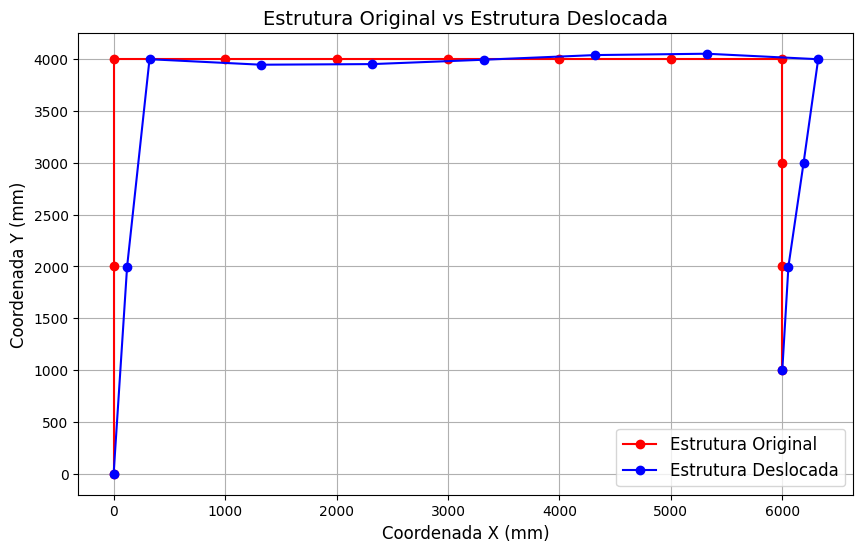

Escala 500% (multiplicando os números por 500)


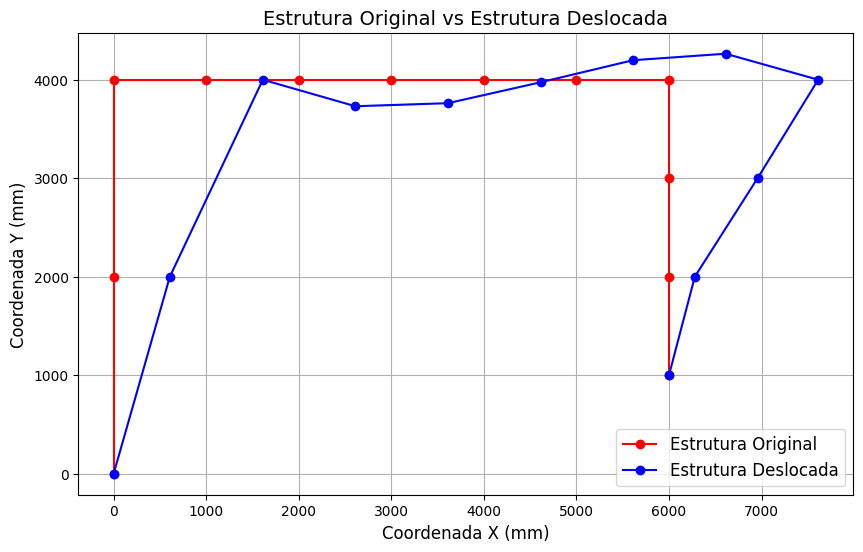

In [728]:
#Discretização 1 da malha:
num_el = 11

#[x,y] = mm
x = [0,0,0,1000,2000,3000,4000,5000,6000,6000,6000,6000]
y = [0,2000,4000,4000,4000,4000,4000,4000,4000,3000,2000,1000]

#Força aplicada sobre os graus de liberdade
#[F]=kN/mm
F =[{"Glib":6,"Forca":10000000},{"Glib":7,"Forca":-10000000/2},{"Glib":10,"Forca":-10000000/2}
    ,
    {"Glib":30,"Forca":-10000000/2},{"Glib":33,"Forca":-10000000/2}
    ]
#Graus de liberdade restringidos (os apoios da estrutura)
RA = [1,2,3,34,35,36]  

MEF1 = ElementosFinitos(x,y,RA,DA,num_el,num_nos_el,num_GLib,E,I,area,F)
R1 = MEF1.CalcElementosFinitos()

print("Escala 100%")
plot_desloc([MEF1.x],[MEF1.y],[R1],[MEF1.num_GLib],100)
print("Escala 500% (multiplicando os números por 500)")
plot_desloc([MEF1.x],[MEF1.y],[R1],[MEF1.num_GLib],500)

GDL    Deslocamento
  1        0.000000e+00
  2        0.000000e+00
  3        0.000000e+00
  4        1.430263e-01
  5        -1.450172e-05
  6        -2.698006e-04
  7        5.070974e-01
  8        -2.900344e-05
  9        -4.420898e-04
 10        9.947021e-01
 11        -4.350516e-05
 12        -5.168676e-04
 13        1.508329e+00
 14        -5.800688e-05
 15        -4.941339e-04
 16        1.508321e+00
 17        -2.254375e-01
 18        -3.818817e-04
 19        1.508312e+00
 20        -3.651700e-01
 21        -1.690113e-04
 22        1.508304e+00
 23        -3.951447e-01
 24        3.968411e-05
 25        1.508296e+00
 26        -3.349146e-01
 27        1.918077e-04
 28        1.508288e+00
 29        -2.127656e-01
 30        2.873595e-04
 31        1.508280e+00
 32        -5.698365e-02
 33        3.263396e-04
 34        1.508272e+00
 35        1.041454e-01
 36        3.087478e-04
 37        1.508264e+00
 38        2.423356e-01
 39        2.345843e-04
 40        1.508255e+00
 41 

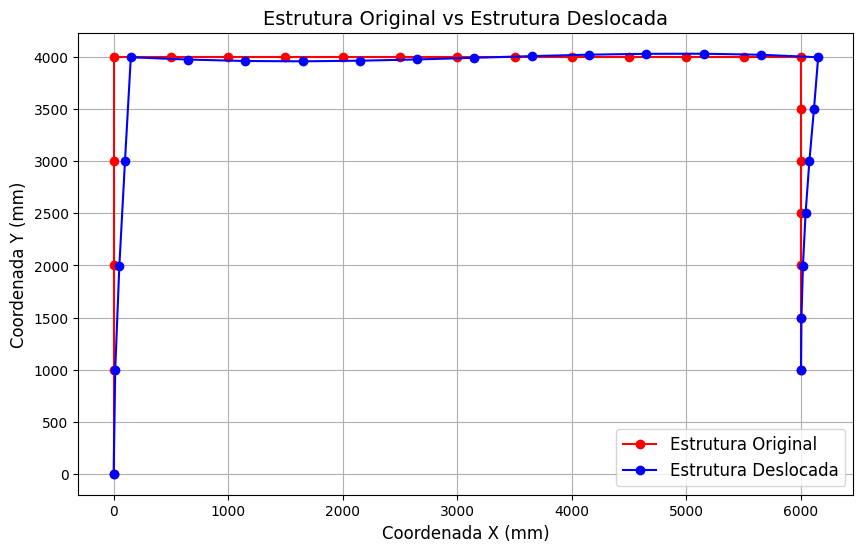

Escala 500% (multiplicando os números por 500)


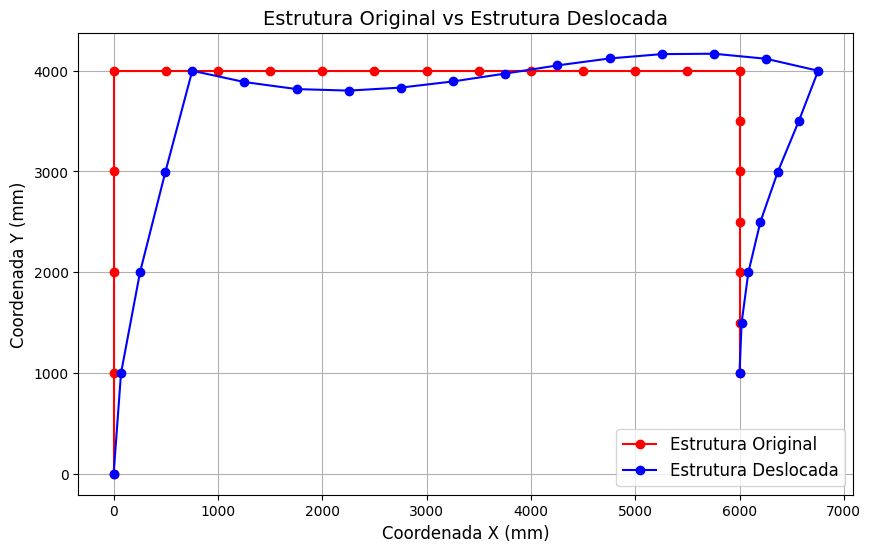

In [729]:
#Discretização 2 da malha:
num_el = 22

#[x,y] = mm
x = [0,0,0,0,0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6000,6000,6000,6000,6000,6000]
y = [0,1000,2000,3000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,3500,3000,2500,2000,1500,1000]

#Força aplicada sobre os graus de liberdade
#[F]=kN/mm
F =[
    {"Glib":12,"Forca":10000000},{"Glib":13,"Forca":-10000000/3},{"Glib":16,"Forca":-10000000/3},{"Glib":19,"Forca":-10000000/3}
    ,
    {"Glib":51,"Forca":-10000000/3},{"Glib":54,"Forca":-10000000/3},{"Glib":57,"Forca":-10000000/3}
    ]
#Graus de liberdade restringidos (os apoios da estrutura)
RA = [1,2,3,67,68,69]  

MEF2 = ElementosFinitos(x,y,RA,DA,num_el,num_nos_el,num_GLib,E,I,area,F)
R2 = MEF2.CalcElementosFinitos()

print("Escala 100%")
plot_desloc([MEF2.x],[MEF2.y],[R2],[MEF2.num_GLib],100)
print("Escala 500% (multiplicando os números por 500)")
plot_desloc([MEF2.x],[MEF2.y],[R2],[MEF2.num_GLib],500)

x = [0, 0, 0, 0, 0, 125.0, 250.0, 375.0, 500.0, 625.0, 750.0, 875.0, 1000.0, 1125.0, 1250.0, 1375.0, 1500.0, 1625.0, 1750.0, 1875.0, 2000.0, 2125.0, 2250.0, 2375.0, 2500.0, 2625.0, 2750.0, 2875.0, 3000.0, 3125.0, 3250.0, 3375.0, 3500.0, 3625.0, 3750.0, 3875.0, 4000.0, 4125.0, 4250.0, 4375.0, 4500.0, 4625.0, 4750.0, 4875.0, 5000.0, 5125.0, 5250.0, 5375.0, 5500.0, 5625.0, 5750.0, 5875.0, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
y = [0, 1000, 2000, 3000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 3900, 3800, 3700, 3600, 3500, 3400, 3300, 3200, 3100, 3000, 2900, 2800, 2700, 2600, 2500, 2400, 2300, 220

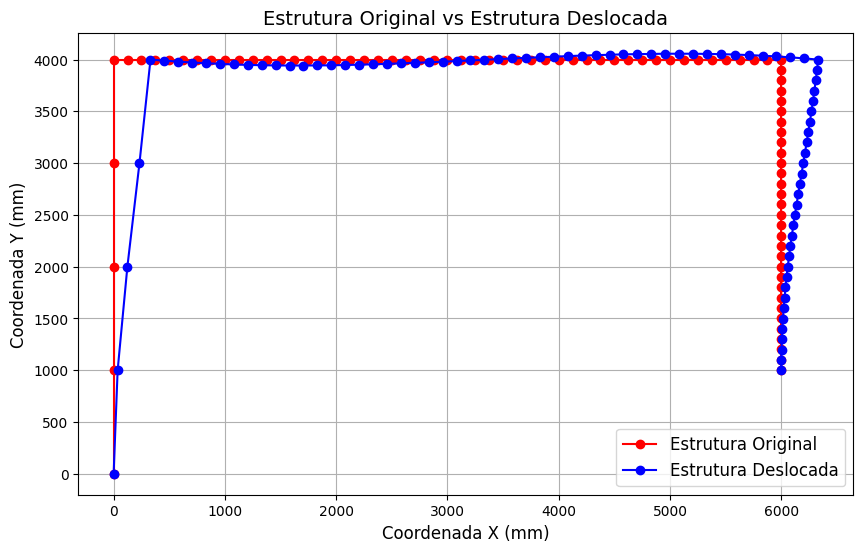

Escala 500% (multiplicando os números por 500)


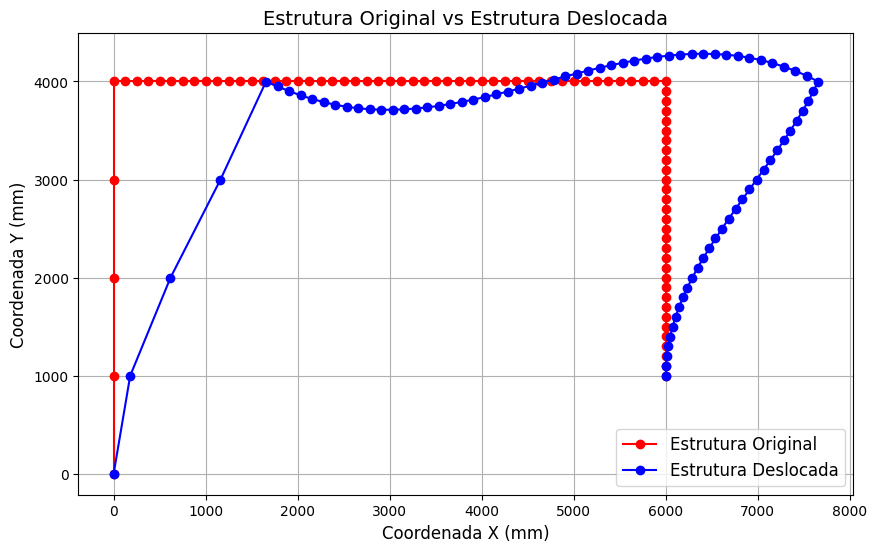

In [730]:
#Discretização 3 da malha:
num_el = 82

# Primeiros 4 pontos(barra h1)

#[x,y] = mm
x = []
y = []
ac = 0

for i in range(4):
    x.append(0)
    y.append(ac)
    ac+=1000

# Próximos 48 pontos (barra L)
ac = 0
for i in range(48):
    x.append(ac)
    ac+=(6000/48)
    y.append(4000)

#Próximos 31 pontos (barra h2)
ac = 4000
for i in range(31):
    x.append(6000)
    y.append(ac)
    ac-=100

print("x =", list(x))
print("y =", list(y))

#Força aplicada sobre os graus de liberdade
#[F]=kN/mm
F =[
    {"Glib":12,"Forca":10000000},{"Glib":13,"Forca":-10000000/9},{"Glib":16,"Forca":-10000000/9},{"Glib":19,"Forca":-10000000/9},{"Glib":22,"Forca":-10000000/9},{"Glib":25,"Forca":-10000000/9},{"Glib":28,"Forca":-10000000/9},{"Glib":31,"Forca":-10000000/9},{"Glib":34,"Forca":-10000000/9},{"Glib":37,"Forca":-10000000/9}
    ,
    {"Glib":213,"Forca":-10000000/12},{"Glib":216,"Forca":-10000000/12},{"Glib":219,"Forca":-10000000/12},{"Glib":222,"Forca":-10000000/12},{"Glib":225,"Forca":-10000000/12},{"Glib":228,"Forca":-10000000/12},{"Glib":231,"Forca":-10000000/12},{"Glib":234,"Forca":-10000000/12},{"Glib":237,"Forca":-10000000/12},{"Glib":240,"Forca":-10000000/12},{"Glib":243,"Forca":-10000000/12},{"Glib":246,"Forca":-10000000/12}
]
#Graus de liberdade restringidos (os apoios da estrutura)
RA = [1,2,3,247,248,249]  

MEF3 = ElementosFinitos(x,y,RA,DA,num_el,num_nos_el,num_GLib,E,I,area,F)
R3 = MEF3.CalcElementosFinitos()

print("Escala 100%")
plot_desloc([MEF3.x],[MEF3.y],[R3],[MEF3.num_GLib],100)
print("Escala 500% (multiplicando os números por 500)")
plot_desloc([MEF3.x],[MEF3.y],[R3],[MEF3.num_GLib],500)


Escala 500% (multiplicando os números por 500)


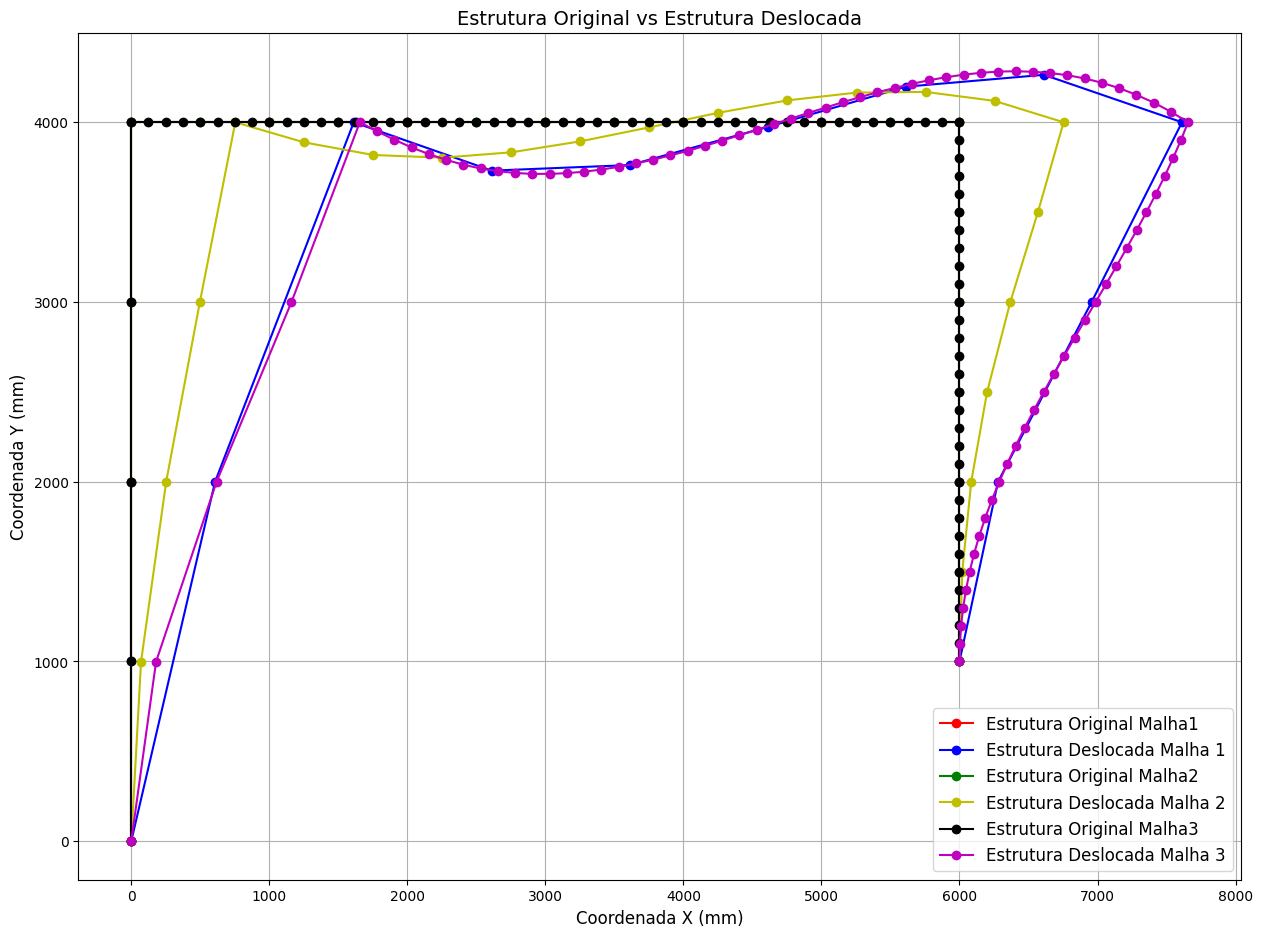

In [731]:
print("Escala 500% (multiplicando os números por 500)")
plot_desloc(
    [MEF1.x,MEF2.x,MEF3.x],
    [MEF1.y,MEF2.y,MEF3.y],
    [R1,R2,R3],
    [MEF1.num_GLib,MEF2.num_GLib,MEF3.num_GLib],
    500,
    (15,11),
    [
        {"color":"ro-","label":"Estrutura Original Malha1"},
        {"color":"go-","label":"Estrutura Original Malha2"},
        {"color":"ko-","label":"Estrutura Original Malha3"},
    ],
    [
        {"color":"bo-","label":"Estrutura Deslocada Malha 1"},
        {"color":"yo-","label":"Estrutura Deslocada Malha 2"},
        {"color":"mo-","label":"Estrutura Deslocada Malha 3"},
    ]
    )